# **Telecom Churn Prediction Case Study**

In the telecommunication industry, customers tend to change operators if not provided with attractive schemes and offers. It is very important for any telecom operator to prevent the present customers from churning to other operators. As a data scientist, your task in this case study would be to build an ML model which can predict if the customer will churn or not in a particular month based on the past data.

#### **Objectives**

The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

- Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

- Recommend strategies to manage customer churn based on your observations.

#### **Import Libraries**

In [1]:
import numpy as np
import pandas as pd

# Importing plot Libraries
import matplotlib.pyplot as plt 
import seaborn as sns

# Importing Data Processing Libraries
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Importing ML Libaries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Import ModelEvaluation Libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

#### **Adjusting Output Settings**

In [2]:
# Ignore version warnings
import warnings
warnings.filterwarnings('ignore')

# Setting Pandas Display options
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth',100)

# Print all the output in Notebook instead of ...
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### **Custom Functions for Univariant and BiVariant Plots, Treating the Outliers**

In [3]:
def data_type(var):
    if var.dtype == np.int64 or var.dtype == np.float64: return 'num'
    elif var.dtype == 'category': return 'cat'

    
def univar_plot_byCheckingColTyp(df, col, vartype , hue = None):
       
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
        
        ax[0].set_title("Box Plot")
        sns.boxplot(data=df, x=col, ax=ax[0], orient='v')
        
        ax[1].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[1])      
    elif vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x=col, order=df[col].value_counts().index, hue=hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        print('Wrong Variable Type is passed, please check.')
        exit
        
    plt.show()
    
    
def univariate(df, col, stats=True):
    
    if data_type(df[col]) == 'num':
        univar_plot_byCheckingColTyp(df, col, 0)
        if stats == True:
            print(df[col].describe())
    
    elif data_type(df[col]) == 'cat':
        univar_plot_byCheckingColTyp(df, col, 1)
        if stats == True:
            print(df[col].value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")

        
def bivariate(df, var1, var2):
    if data_type(df[var1]) == 'num' and data_type(df[var2]) == 'num':
        sns.regplot(df[var1], df[var2])
    elif (data_type(df[var1]) == 'cat' and data_type(df[var2]) == 'num') or (data_type(df[var1]) == 'num' and data_type(df[var2]) == 'cat'):
        sns.boxplot(df[var1], df[var2])
        
        
## Standard Deviation Outlier Treatment 

def std_dev_cap_outliers(data, k = 10):
    upper_limit = data.mean() + k * data.std()
    lower_limit = data.mean() - k * data.std()
    data[data < lower_limit] = lower_limit
    data[data > upper_limit] = upper_limit
    return data
   

#### **Data Understanding**

In [4]:
data_dictionary = pd.read_csv('data_dictionary.csv')
data_dictionary

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [5]:
#Loading the train and test data.

df_train = pd.read_csv('train.csv')
df_test_unseen = pd.read_csv('test.csv')

RESULT_TEST_FILEPATH = './result_Tegbirsingh_Jagadeeshjunjuri.csv'

In [6]:
# Checking Headers
df_train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [7]:
# Checking count of Rows and Columns in Dataset and View List of Data Types and count of columns
print('Train Data Details')
print(df_train.shape)
print(df_train.info(verbose=True))

Train Data Details
(69999, 172)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_

In [8]:
print('Test Data Details')
print(df_test_unseen.shape)
print(df_test_unseen.info())

Test Data Details
(30000, 171)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 171 entries, id to jun_vbc_3g
dtypes: float64(135), int64(27), object(9)
memory usage: 39.1+ MB
None


In [9]:
# Statistical description of Data
df_train.describe(include='all', percentiles=[0.05,0.25,0.5,0.75,0.95])

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,68898,68765,67538,69999.000000,69999.000000

In [10]:
df_test_unseen.describe(include='all',percentiles=[0.05,0.25,0.5,0.75,0.95])

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,30000.000000,30000.0,29684.0,29684.0,29684.0,30000,29798,29633,30000.000000,30000.000000,30000.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.0,28828.0,28325.0,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,30000.000000,30000.000000,30000.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.0,28828.0,28325.0,28831.000000,28828.000000,28325.000000,30000.000000,30000.000000,30000.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,29494,29467,28839,30000.000000,30000.000000,30000.000000,7585

#### **Observations:**
* Data has Null values and outliers
* Data has some columns with 0 variance, i.e. all same values

In [11]:
df_train.id.nunique()

69999

In [12]:
df_train.circle_id.nunique()

1

#### **Observations:**
* ID Column has incremental values
* Circle Id has 0 variance

In [13]:
#Checking emptry rows in training dataset
empty_rows = df_train.isnull().all(axis=1).sum()
print(f'No. Empty Rows: {empty_rows}')

No. Empty Rows: 0


In [14]:
#Checking empty columns in training dataset
empty_columns = df_train.isnull().all(axis=0).sum()
print(f'No. Empty Columns: {empty_columns}')

No. Empty Columns: 0


#### **Observations:**
* Data has no empty rows and columns

In [15]:
# Printing Value counts of all columns and saving the columns with only 1 value in a list

def single_val_cols(data=df_train,verbose=False, value=False):

#     @params:
#            data: Dataframe that needs to be checked; Default: df
#            verbose: Set as True if you want info regarding value counts of each column; Default: False
#     @Return:
#            Returns a list of columns which have 0 variance

    single_val = []
    for col in data.columns :
        val_count = data[col].value_counts()
        if len(val_count) == 1:
            single_val.append(col)
        # Printing the columns and value counts
        if(verbose):
            print("Column Name:",col)
            print("Value Count:",len(val_count))
            if(not value):
                print("====================================")
        if(value):
            if(not verbose):
                print("Column Name:",col) 
            print("Unique Values:", data[col].unique())
            print("====================================")
    print("Columns with 0 Variance:")
    print(single_val)
    return single_val

single_val = single_val_cols(data=df_train,verbose=False)

Columns with 0 Variance:
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [16]:
# Checking for null/NaN values

def get_missing_info(data=df_train, limit=0, verbose=False) :
    # @Params:
    #        data: Dataframe to be checked; Default=df
    #        limit: Threshold for Percentage of Null values; Default=0
    #        verbose: Set as True if you want to print the entire table of features above the threashold limit
    # @Return: A dataframe with info of missing values
    
    percent_missing  = data.isnull().sum() * 100 / len(data)
    missing_value_df = pd.DataFrame({'column_name': data.columns,
                                     'percent_missing': percent_missing})
    # Sorting in descending order of perc missing
    missing_value_df.sort_values('percent_missing', inplace=True,ascending= False)
    missing_value_df.reset_index(drop=True, inplace=True)
    if (limit != 0) :
        print("No of columns with more than/equal to",limit,"% null values: ",len(missing_value_df[missing_value_df.percent_missing >= limit]))
    if(verbose):
        print("Columns with more than/equal to",limit,"% null values:")
        print(missing_value_df[missing_value_df.percent_missing >= limit])
    return missing_value_df
missing_info = get_missing_info(data=df_train,limit=30, verbose=True)

No of columns with more than/equal to 30 % null values:  30
Columns with more than/equal to 30 % null values:
                 column_name  percent_missing
0                  arpu_3g_6        74.902499
1            count_rech_2g_6        74.902499
2           night_pck_user_6        74.902499
3                  arpu_2g_6        74.902499
4   date_of_last_rech_data_6        74.902499
5          total_rech_data_6        74.902499
6         av_rech_amt_data_6        74.902499
7            max_rech_data_6        74.902499
8            count_rech_3g_6        74.902499
9                  fb_user_6        74.902499
10          night_pck_user_7        74.478207
11  date_of_last_rech_data_7        74.478207
12         total_rech_data_7        74.478207
13           max_rech_data_7        74.478207
14                 fb_user_7        74.478207
15           count_rech_2g_7        74.478207
16           count_rech_3g_7        74.478207
17                 arpu_3g_7        74.478207
18        av_rec

####  **Data Cleaning and Manipulation**

In [17]:
# Creating a copy of 'df_train' to clean & transform data
df_train_cleaned = df_train
df_test_unseen_cleaned = df_test_unseen

In [18]:
#As features count is too high, let's try to seperate them w.r.t data understanding.
id_cols = ['id', 'circle_id']

date_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8'
            ]

cat_cols =  ['night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'fb_user_6',
             'fb_user_7',
             'fb_user_8'
            ]
target_cols = ['churn_probability']

In [19]:
num_cols = [column for column in df_train.select_dtypes(include=['int64','float64']) if column not in (id_cols + cat_cols + target_cols)]

# Print the number of columns in each list
print("ID columns: ", len(id_cols))
print("DATE columns: ", len(date_cols)) 
print("NUM cols: ", len(num_cols))
print("CATEGORY cols: ", len(cat_cols))
print("TARGET cols: ", len(target_cols))
print("TOTAL SUM: ", len(id_cols) + len(date_cols) + len(num_cols) + len(cat_cols) + len(target_cols))
print("TOTAL Columns: ", df_train.shape[1])

# Validate if we have missed any column or not
print("Checking segregation is done correctly : ",len(id_cols) + len(date_cols) + len(num_cols) + len(cat_cols) + len(target_cols) == df_train.shape[1])


ID columns:  2
DATE columns:  9
NUM cols:  154
CATEGORY cols:  6
TARGET cols:  1
TOTAL SUM:  172
TOTAL Columns:  172
Checking segregation is done correctly :  True


In [20]:
# some recharge data columns have minimum value of 1 while some don't
rech_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'
                 ]

df_train_cleaned[rech_cols].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,2.467612,2.679989,2.652441,1.865323,2.056311,2.016018,0.602288,0.623678,0.636423,126.500000,126.402071,125.374925,192.831096,201.455940,196.815792
std,2.794610,3.073472,3.101265,2.566377,2.799916,2.728246,1.279297,1.401230,1.457058,109.352573,109.459266,109.648799,190.623115,198.346141,192.280532
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,82.000000,92.000000,84.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,145.000000,145.000000,145.000000,154.000000,154.000000,154.000000
75%,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,177.000000,177.000000,179.000000,252.000000,252.000000,252.000000
max,61.000000,54.000000,60.000000,42.000000,48.000000,44.000000,29.000000,34.000000,45.000000,1555.000000,1555.000000,1555.000000,5920.000000,4365.000000,4076.000000


In [21]:
# Recharge date and the recharge value are missing in same month, that is customer not recharged service in that particular month
df_train_cleaned.loc[df_train_cleaned.total_rech_data_6.isnull() & df_train_cleaned.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(5)
df_train_cleaned.loc[df_train_cleaned.total_rech_data_7.isnull() & df_train_cleaned.date_of_last_rech_data_7.isnull(), ["total_rech_data_7", "date_of_last_rech_data_7"]].head(5)
df_train_cleaned.loc[df_train_cleaned.total_rech_data_8.isnull() & df_train_cleaned.date_of_last_rech_data_8.isnull(), ["total_rech_data_8", "date_of_last_rech_data_8"]].head(5)
df_train_cleaned[["total_rech_data_6", "date_of_last_rech_data_6","total_rech_data_7", "date_of_last_rech_data_7","total_rech_data_8", "date_of_last_rech_data_8"]].head()

,total_rech_data_6,date_of_last_rech_data_6
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN


,total_rech_data_7,date_of_last_rech_data_7
0,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN
6,NaN,NaN


,total_rech_data_8,date_of_last_rech_data_8
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN


,total_rech_data_6,date_of_last_rech_data_6,total_rech_data_7,date_of_last_rech_data_7,total_rech_data_8,date_of_last_rech_data_8
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,7/8/2014,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,7.0,6/25/2014,7.0,7/23/2014,6.0,8/20/2014


#### **Observations:**
* Recharge is not done in some months, thus there is no record available; Hence, we can replace null values with 0

In [22]:
# List of recharge columns where we will impute missing values with 0s
impute_0s = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
             'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']

In [23]:
# impute missing values with 0 in both train and unseen test data
df_train_cleaned[impute_0s] = df_train_cleaned[impute_0s].fillna(0)
df_test_unseen_cleaned[impute_0s] = df_test_unseen[impute_0s].fillna(0)

In [24]:
# Verifying the recharge columns with manual imputation
print("Missing value percentage in TRAIN Recharge Columns:")
get_missing_info(data=df_train_cleaned[impute_0s])

# Verification of 0s imputation (TEST)
print("Missing value percentage in TEST Recharge Columns:")
get_missing_info(data=df_test_unseen_cleaned[impute_0s])

Missing value percentage in TRAIN Recharge Columns:


,column_name,percent_missing
0,total_rech_data_6,0.0
1,total_rech_data_7,0.0
2,total_rech_data_8,0.0
3,av_rech_amt_data_6,0.0
4,av_rech_amt_data_7,0.0
5,av_rech_amt_data_8,0.0
6,max_rech_data_6,0.0
7,max_rech_data_7,0.0
8,max_rech_data_8,0.0


Missing value percentage in TEST Recharge Columns:


,column_name,percent_missing
0,total_rech_data_6,0.0
1,total_rech_data_7,0.0
2,total_rech_data_8,0.0
3,av_rech_amt_data_6,0.0
4,av_rech_amt_data_7,0.0
5,av_rech_amt_data_8,0.0
6,max_rech_data_6,0.0
7,max_rech_data_7,0.0
8,max_rech_data_8,0.0


In [25]:
# Lets see rech columns stats for train dataset
df_train_cleaned[impute_0s].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,0.619309,0.683981,0.697867,48.395787,51.415168,51.782975,31.748339,32.260075,32.986614
std,1.762010,1.943193,1.973434,126.923180,133.246541,131.291162,77.519536,78.069163,78.808337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,8.000000,17.000000,23.000000,8.000000,14.000000,17.000000
max,61.000000,54.000000,60.000000,5920.000000,4365.000000,4076.000000,1555.000000,1555.000000,1555.000000


In [26]:
# Lets see rech columns stats for test dataset
df_test_unseen_cleaned[impute_0s].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.620700,0.676833,0.700033,48.561194,51.342741,52.596458,31.894033,32.747533,33.407933
std,1.757138,1.879782,1.939874,129.640618,131.180208,130.929389,76.614487,78.976636,79.023333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,14.000000,17.000000,23.000000,14.000000,17.000000,17.000000
max,55.000000,44.000000,57.000000,7546.000000,3765.000000,2520.000000,1555.000000,1555.000000,1555.000000


In [27]:
# we can drop id columns and date columns as there is not much significance
df_train_cleaned = df_train_cleaned.drop(id_cols + date_cols, axis=1)
df_train_cleaned.shape

(69999, 161)

In [28]:
# doing the same for test data
df_test_unseen_cleaned = df_test_unseen_cleaned.drop(id_cols + date_cols, axis=1)
df_test_unseen_cleaned.shape

(30000, 160)

#### **Fixing Null values for Category columns**


In [29]:
single_val_cols(data=df_train_cleaned[cat_cols], verbose=True, value=True)

Column Name: night_pck_user_6
Value Count: 2
Unique Values: [nan  0.  1.]
Column Name: night_pck_user_7
Value Count: 2
Unique Values: [nan  0.  1.]
Column Name: night_pck_user_8
Value Count: 2
Unique Values: [nan  0.  1.]
Column Name: fb_user_6
Value Count: 2
Unique Values: [nan  1.  0.]
Column Name: fb_user_7
Value Count: 2
Unique Values: [nan  1.  0.]
Column Name: fb_user_8
Value Count: 2
Unique Values: [nan  1.  0.]
Columns with 0 Variance:
[]


[]

#### **Observations:**
* We can see that the cat columns have Nan/Null values, Let's replace them with -1 to indicate that these are not relevant

In [30]:
df_train_cleaned[cat_cols] = df_train_cleaned[cat_cols].fillna(-1)
df_test_unseen_cleaned[cat_cols] = df_test_unseen_cleaned[cat_cols].fillna(-1)

In [31]:
# Verifying the category columns with manual imputation
print("Missing value parcentage TRAIN:")
get_missing_info(data= df_train_cleaned[cat_cols])

print("Missing value parcentage TEST:")
get_missing_info(data= df_test_unseen_cleaned[cat_cols])

Missing value parcentage TRAIN:


,column_name,percent_missing
0,night_pck_user_6,0.0
1,night_pck_user_7,0.0
2,night_pck_user_8,0.0
3,fb_user_6,0.0
4,fb_user_7,0.0
5,fb_user_8,0.0


Missing value parcentage TEST:


,column_name,percent_missing
0,night_pck_user_6,0.0
1,night_pck_user_7,0.0
2,night_pck_user_8,0.0
3,fb_user_6,0.0
4,fb_user_7,0.0
5,fb_user_8,0.0


#### **Dropping columns with more than 70% null values**

In [32]:
missing_cols_70 = get_missing_info(data=df_train_cleaned, limit=70, verbose=False)
missing_cols_70[missing_cols_70.percent_missing >= 70]

No of columns with more than/equal to 70 % null values:  12


,column_name,percent_missing
0,count_rech_3g_6,74.902499
1,arpu_2g_6,74.902499
2,count_rech_2g_6,74.902499
3,arpu_3g_6,74.902499
4,arpu_2g_7,74.478207
5,count_rech_2g_7,74.478207
6,count_rech_3g_7,74.478207
7,arpu_3g_7,74.478207
8,arpu_3g_8,73.689624
9,count_rech_2g_8,73.689624


In [33]:
initial_n_columns = df_train_cleaned.shape[1]

MISSING_THRESHOLD = 0.7

include_columns = list(df_train_cleaned.apply(lambda column: True if column.isnull().sum()/df_train_cleaned.shape[0] < MISSING_THRESHOLD else False))

drop_missing = pd.DataFrame({'features':df_train_cleaned.columns , 'include': include_columns})
drop_missing.loc[drop_missing.include == True,:]

,features,include
0,loc_og_t2o_mou,True
1,std_og_t2o_mou,True
2,loc_ic_t2o_mou,True
3,arpu_6,True
4,arpu_7,True
5,arpu_8,True
6,onnet_mou_6,True
7,onnet_mou_7,True
8,onnet_mou_8,True
9,offnet_mou_6,True


In [34]:
#columns to drop
drop_missing.loc[drop_missing.include == False,:].reset_index()

,index,features,include
0,117,count_rech_2g_6,False
1,118,count_rech_2g_7,False
2,119,count_rech_2g_8,False
3,120,count_rech_3g_6,False
4,121,count_rech_3g_7,False
5,122,count_rech_3g_8,False
6,132,arpu_3g_6,False
7,133,arpu_3g_7,False
8,134,arpu_3g_8,False
9,135,arpu_2g_6,False


In [35]:
df_train_cleaned = df_train_cleaned.loc[:, include_columns]


In [36]:
df_test_unseen_cleaned = df_test_unseen_cleaned.loc[:, include_columns[:-1]]

In [37]:
get_missing_info(data=df_train_cleaned)
#(df_train_cleaned.isnull().sum() * 100 / len(df_train_cleaned)).sort_values(ascending = False)

,column_name,percent_missing
0,std_ic_t2t_mou_8,5.290076
1,spl_og_mou_8,5.290076
2,loc_og_t2c_mou_8,5.290076
3,loc_og_mou_8,5.290076
4,std_og_t2t_mou_8,5.290076
5,std_og_t2m_mou_8,5.290076
6,std_og_t2f_mou_8,5.290076
7,std_og_t2c_mou_8,5.290076
8,std_og_mou_8,5.290076
9,isd_og_mou_8,5.290076


In [38]:
df_train_cleaned.shape

(69999, 149)

#### **To fix the null values we can use IterativeImputer sklearn function**

In [39]:
ite_imputer = IterativeImputer(max_iter=1, verbose=2)
ite_imputer.fit(df_train_cleaned)

[IterativeImputer] Completing matrix with shape (69999, 149)
[IterativeImputer] Ending imputation round 1/1, elapsed time 73.91
[IterativeImputer] Change: 3166.0664237068736, scaled tolerance: 45.735400000000006 


IterativeImputer(max_iter=1, verbose=2)

In [40]:
# IterativeImputer on train dataset
df_train_cleaned_imputed = ite_imputer.transform(df_train_cleaned)
df_train_cleaned_imputed = pd.DataFrame(df_train_cleaned_imputed, columns=df_train_cleaned.columns)

[IterativeImputer] Completing matrix with shape (69999, 149)
[IterativeImputer] Ending imputation round 1/1, elapsed time 1.84


In [41]:
# IterativeImputer on test dataset
ite_imputer = IterativeImputer(max_iter=1, verbose=2)
ite_imputer.fit(df_test_unseen_cleaned)
df_test_unseen_cleaned_imputed = ite_imputer.transform(df_test_unseen_cleaned)
df_test_unseen_cleaned_imputed = pd.DataFrame(df_test_unseen_cleaned_imputed, columns=df_test_unseen_cleaned.columns)

[IterativeImputer] Completing matrix with shape (30000, 148)
[IterativeImputer] Ending imputation round 1/1, elapsed time 26.94
[IterativeImputer] Change: 2668.0458773857627, scaled tolerance: 28.06593 


IterativeImputer(max_iter=1, verbose=2)

[IterativeImputer] Completing matrix with shape (30000, 148)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.92


In [42]:
#verifying the null values for train dataset
get_missing_info(data=df_train_cleaned_imputed)

,column_name,percent_missing
0,loc_og_t2o_mou,0.0
1,isd_ic_mou_7,0.0
2,ic_others_6,0.0
3,ic_others_7,0.0
4,ic_others_8,0.0
5,total_rech_num_6,0.0
6,total_rech_num_7,0.0
7,total_rech_num_8,0.0
8,total_rech_amt_6,0.0
9,total_rech_amt_7,0.0


In [43]:
#verifying the null values for test dataset
get_missing_info(data=df_test_unseen_cleaned_imputed)

,column_name,percent_missing
0,loc_og_t2o_mou,0.0
1,isd_ic_mou_6,0.0
2,isd_ic_mou_8,0.0
3,ic_others_6,0.0
4,ic_others_7,0.0
5,ic_others_8,0.0
6,total_rech_num_6,0.0
7,total_rech_num_7,0.0
8,total_rech_num_8,0.0
9,total_rech_amt_6,0.0


#### **Finding high value Customers from given dataset using derived columns**

In [44]:
# calculate the total data recharge amount for June, July and Aug 
# Total Recharge = number of recharges * average recharge amount
df_train_cleaned_imputed['total_data_rech_6'] = df_train_cleaned_imputed.total_rech_data_6 * df_train_cleaned_imputed.av_rech_amt_data_6
df_train_cleaned_imputed['total_data_rech_7'] = df_train_cleaned_imputed.total_rech_data_7 * df_train_cleaned_imputed.av_rech_amt_data_7
df_train_cleaned_imputed['total_data_rech_8'] = df_train_cleaned_imputed.total_rech_data_8 * df_train_cleaned_imputed.av_rech_amt_data_8

# for TEST
df_test_unseen_cleaned_imputed['total_data_rech_6'] = df_test_unseen_cleaned_imputed.total_rech_data_6 * df_test_unseen_cleaned_imputed.av_rech_amt_data_6
df_test_unseen_cleaned_imputed['total_data_rech_7'] = df_test_unseen_cleaned_imputed.total_rech_data_7 * df_test_unseen_cleaned_imputed.av_rech_amt_data_7
df_test_unseen_cleaned_imputed['total_data_rech_8'] = df_test_unseen_cleaned_imputed.total_rech_data_8 * df_test_unseen_cleaned_imputed.av_rech_amt_data_8

#### To find the Total amount we need to add recharge amount + total data recharge amount

In [45]:
# calculate total recharge amount for June and July --> call recharge amount + data recharge amount
df_train_cleaned_imputed['amt_data_6'] = df_train_cleaned_imputed.total_rech_amt_6 + df_train_cleaned_imputed.total_data_rech_6
df_train_cleaned_imputed['amt_data_7'] = df_train_cleaned_imputed.total_rech_amt_7 + df_train_cleaned_imputed.total_data_rech_7
df_train_cleaned_imputed['amt_data_8'] = df_train_cleaned_imputed.total_rech_amt_8 + df_train_cleaned_imputed.total_data_rech_8

# for TEST
df_test_unseen_cleaned_imputed['amt_data_6'] = df_test_unseen_cleaned_imputed.total_rech_amt_6 + df_test_unseen_cleaned_imputed.total_data_rech_6
df_test_unseen_cleaned_imputed['amt_data_7'] = df_test_unseen_cleaned_imputed.total_rech_amt_7 + df_test_unseen_cleaned_imputed.total_data_rech_7
df_test_unseen_cleaned_imputed['amt_data_8'] = df_test_unseen_cleaned_imputed.total_rech_amt_8 + df_test_unseen_cleaned_imputed.total_data_rech_8

In [46]:
# Calculating avg amount spend by customers
df_train_cleaned_imputed['av_amt_data_6_7_8'] = (df_train_cleaned_imputed.amt_data_6 + df_train_cleaned_imputed.amt_data_7 + df_train_cleaned_imputed.amt_data_8)/3

# for TEST
df_test_unseen_cleaned_imputed['av_amt_data_6_7_8'] = (df_test_unseen_cleaned_imputed.amt_data_6 + df_test_unseen_cleaned_imputed.amt_data_7 + df_test_unseen_cleaned_imputed.amt_data_8)/2

#### **Considering 70th percentile as the cutoff for High Value Customers**

In [47]:
# look at the 70th percentile recharge amount
print("Recharge amount at 70th percentile (TRAIN): {0}".format(df_train_cleaned_imputed.av_amt_data_6_7_8.quantile(0.7)))

Recharge amount at 70th percentile (TRAIN): 484.3333333333333


In [48]:
#Since we need to focus on high-value customer, lets retain the records which have more than 70%

df_train_filtered = df_train_cleaned_imputed.loc[df_train_cleaned_imputed.av_amt_data_6_7_8 >= df_train_cleaned_imputed.av_amt_data_6_7_8.quantile(0.7), :]
df_train_filtered = df_train_filtered.reset_index(drop = True)
print(df_train_filtered.shape)

# for TEST (WE DO NOT REMOVE ROWS for TEST)
df_test_filtered = df_test_unseen_cleaned_imputed
df_test_filtered = df_test_filtered.reset_index(drop = True)
print(df_test_filtered.shape)

(21001, 156)
(30000, 155)


In [49]:
# Delete variables created to filter high-value customers
drop_columns_high_value = ['total_data_rech_6', 'total_data_rech_7','total_data_rech_8',
                           'amt_data_6', 'amt_data_7','amt_data_8', 'av_amt_data_6_7_8']
df_train_filtered = df_train_filtered.drop(drop_columns_high_value, axis=1)
df_train_filtered.shape


(21001, 149)

In [50]:
# Delete variables in TEST created to filter high-value customers in TRAIN
df_test_filtered = df_test_filtered.drop(drop_columns_high_value, axis=1)

#### **Observations:**
* We're left with 21001 rows after selecting the customers who have provided recharge value of more than or equal to the recharge value of the 70th percentile customer.

#### **Deriving New Features**

In [51]:
# Calculate total incoming and outgoing minutes of usage in TRAIN
#df_train_filtered['total_calls_mou_8'] = df_train_filtered.total_ic_mou_8 + df_train_filtered.total_og_mou_8


In [52]:
# calculate 2g and 3g data consumption
#df_train_filtered['total_internet_mb_8'] =  df_train_filtered.vol_2g_mb_8 + df_train_filtered.vol_3g_mb_8

In [53]:
# Create "Churn Variable": those who have not used either calls or internet in the month 8 are customers who have churned
# 0 = Not churn, 1 = Churn
#df_train_filtered['churn'] = df_train_filtered.apply(lambda row: 1 if (row.total_calls_mou_8 == 0 and row.total_internet_mb_8 == 0) else 0, axis=1)


In [54]:
# Delete derived variables just created
# df_train_filtered = df_train_filtered.drop(['total_calls_mou_8', 'total_internet_mb_8'], axis=1)

In [55]:
#Remaning column for the ease of utilization
df_train_filtered.rename(columns = {'churn_probability':'churn'}, inplace = True)

In [56]:
# Change data type to category
df_train_filtered.churn = df_train_filtered.churn.astype("category")

# print churn ratio
print("Churn Ratio:")
print(df_train_filtered.churn.value_counts()*100/df_train_filtered.shape[0])

Churn Ratio:
0.0    94.014571
1.0     5.985429
Name: churn, dtype: float64


In [57]:
# Show details for columns
df_train_filtered.describe()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,21001.0,21001.0,21001.0,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.00000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.0,21001.0,21001.0,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.0,21001.0,21001.0,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.00000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,2

#### **Checking for Columns with 0 Variance**

In [58]:
single_cols_filtered = single_val_cols(data=df_train_filtered)

Columns with 0 Variance:
['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [59]:
# Dropping columns with 0 variance
df_train_filtered = df_train_filtered.drop(columns = single_cols_filtered)
df_test_filtered = df_test_filtered.drop(columns = single_cols_filtered)

In [60]:
# Shape of TRAIN and TEST. They should remain the same
print("TRAIN Shape: ", df_train_filtered.shape)
print("TEST Shape: ", df_test_filtered.shape)

TRAIN Shape:  (21001, 140)
TEST Shape:  (30000, 139)


#### **Observations:**
* Train data has additional "churn" field

#### **Univariable Analysis**

In [61]:
df_train_filtered.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
0,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.0,0.0,0.00,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,21.54,9.36,28.31,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,13.0,10.0,8.0,290.0,136.0,122.0,50.0,41.0,30.0,25.0,10.0,30.0,7.0,7.0,6.0,25.0,41.0,25.0,175.0,191.0,142.0,390.80,308.89,213.47,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,647.0,0.0,0.00,0.00,0.0
1,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,0.00,0.0,0.0,0.00,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.00,0.00,327.46,366.79,385.26,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,6.26,0.00,0.00,6.26,0.0,0.0,0.0,0.08,0.00,0.00,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.00,1.93,8.88,233.18,776.36,629.94,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.03,0.0,0.00,1.03,0.00,233.18,777.39,629.94,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,5.0,3.0,4.0,654.0,400.0,652.0,250.0,250.0,250.0,0.0,150.0,250.0,1.0,0.0,1.0,154.0,0.0,154.0,154.0,0.0,154.0,260.42,0.00,354.35,0.0,0.00,0.00,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,602.0,0.0,0.00,0.00,0.0
2,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,0.00,0.0,0.0,0.00,0.0,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.0,0.00,0.00,950.91,822.78,387.79,0.00,0.00,0.00,202.08,0.00,0.00,0.0,0.0,0.00,202.08,0.00,0.00,0.0,0.0,0.0,0.00,0.05,0.01,0.0,0.0,0.0,1152.99,822.83,387.81,233.28,117.63,30.39,123.78,278.49,148.83,34.31,52.08,23.66,391.38,448.21,202.89,0.0,0.00,0.00,207.03,0.00,0.00,0.00,0.00,0.0,207.03,0.00,0.00,598.54,448.36,203.29,0.13,0.0,0.0,0.00,0.00,0.00,0.0,0.15,0.4,26.0,19.0,10.0,1420.0,99

#### **Plot Numeric Data**

In [62]:
print("Categorical Columns\n", cat_cols)
print("\nNumerical Columns\n", num_cols)

Categorical Columns
 ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

Numerical Columns
 ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'is

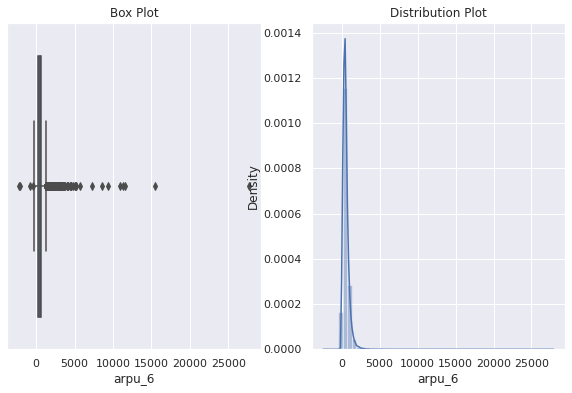

count    21001.000000
mean       538.233159
std        480.753447
min      -2258.709000
25%        279.284000
50%        460.447000
75%        684.408000
max      27731.088000
Name: arpu_6, dtype: float64


In [63]:
univariate(df_train_filtered, 'arpu_6')

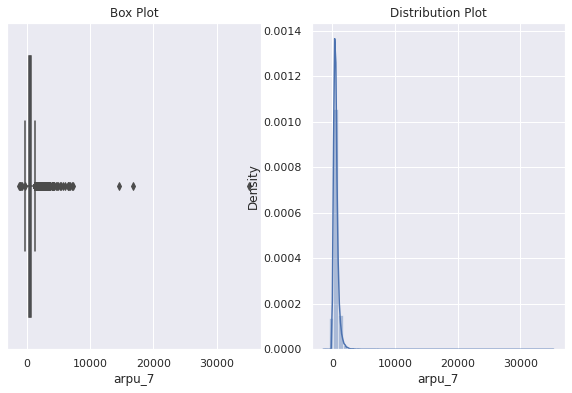

count    21001.000000
mean       554.883200
std        496.448295
min      -1289.715000
25%        300.883000
50%        476.909000
75%        695.703000
max      35145.834000
Name: arpu_7, dtype: float64


In [64]:
univariate(df_train_filtered, 'arpu_7')

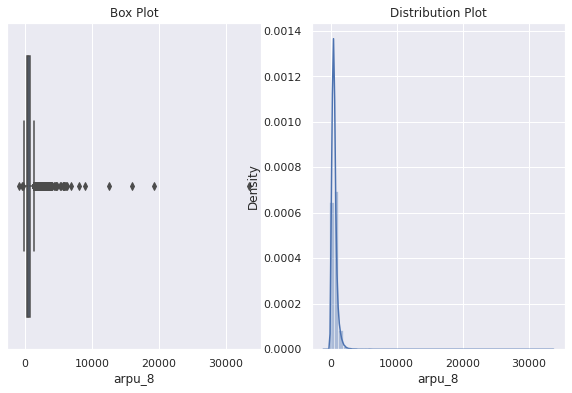

count    21001.000000
mean       548.392801
std        514.834686
min       -945.808000
25%        286.422000
50%        470.956000
75%        690.040000
max      33543.624000
Name: arpu_8, dtype: float64


In [65]:
univariate(df_train_filtered, 'arpu_8')

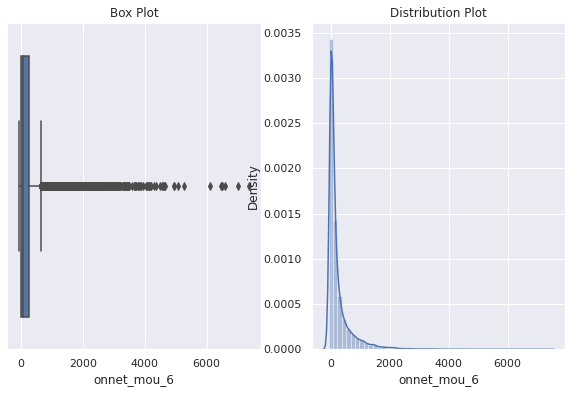

count    21001.000000
mean       248.021426
std        457.127696
min        -66.943668
25%         14.280000
50%         77.590000
75%        268.460000
max       7376.710000
Name: onnet_mou_6, dtype: float64


In [66]:
univariate(df_train_filtered, 'onnet_mou_6')

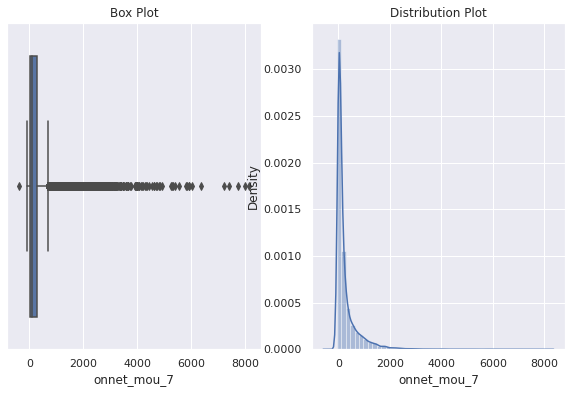

count    21001.000000
mean       265.702337
std        486.944958
min       -398.308292
25%         15.080000
50%         80.680000
75%        285.440000
max       8157.780000
Name: onnet_mou_7, dtype: float64


In [67]:
univariate(df_train_filtered, 'onnet_mou_7')

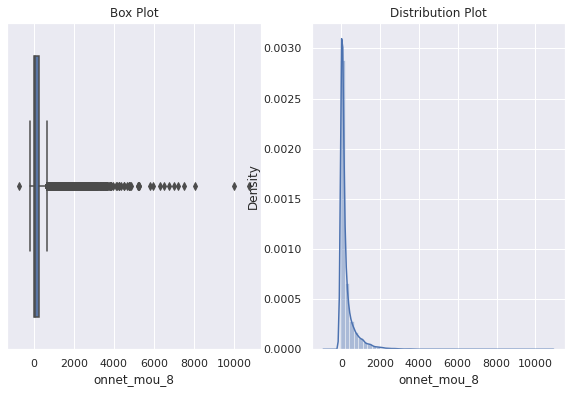

count    21001.000000
mean       252.204226
std        481.968016
min       -750.579289
25%         13.430000
50%         74.440000
75%        266.130000
max      10752.560000
Name: onnet_mou_8, dtype: float64


In [68]:
univariate(df_train_filtered, 'onnet_mou_8')

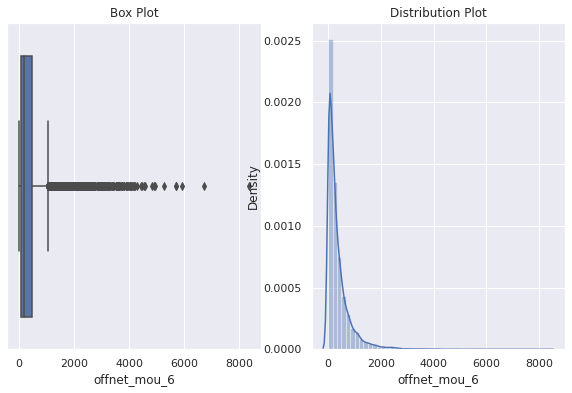

count    21001.000000
mean       362.725563
std        473.092005
min          0.000000
25%         73.340000
50%        207.310000
75%        467.260000
max       8362.360000
Name: offnet_mou_6, dtype: float64


In [69]:
univariate(df_train_filtered, 'offnet_mou_6')

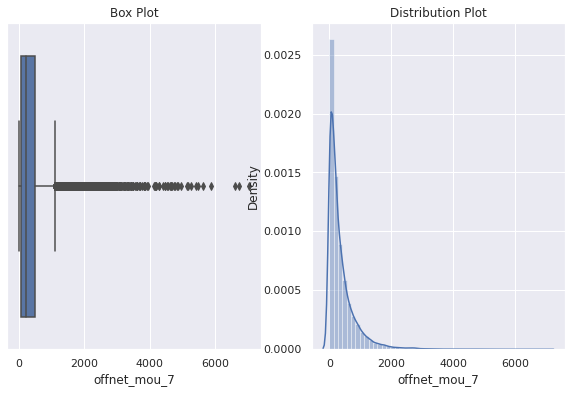

count    21001.000000
mean       377.885500
std        489.902003
min          0.000000
25%         76.710000
50%        215.110000
75%        490.560000
max       7043.980000
Name: offnet_mou_7, dtype: float64


In [70]:
univariate(df_train_filtered, 'offnet_mou_7')

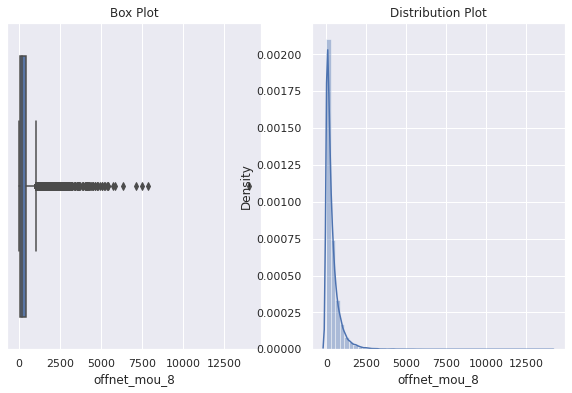

count    21001.000000
mean       364.124811
std        487.487890
min          0.000000
25%         70.430000
50%        207.780000
75%        470.080000
max      14007.340000
Name: offnet_mou_8, dtype: float64


In [71]:
univariate(df_train_filtered, 'offnet_mou_8')

#### **Observations:**
* Variables are skewed todards left. with many outliers

#### **Plot Categorical Data**

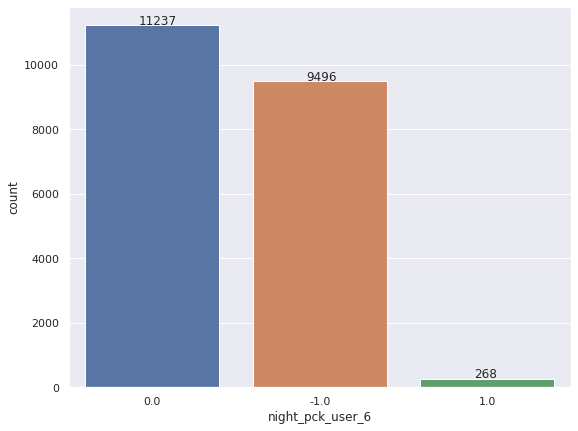

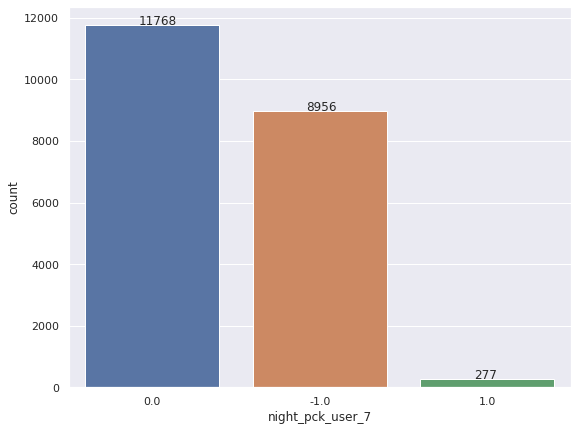

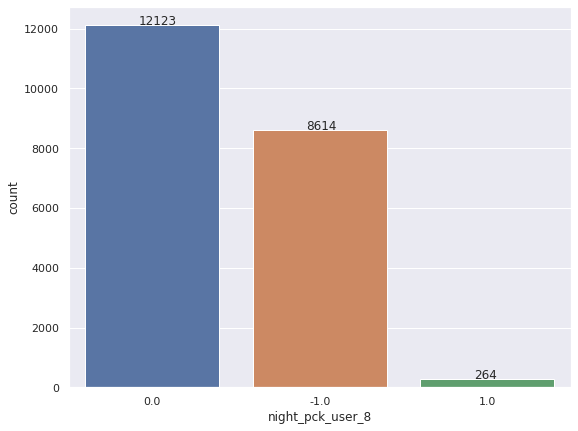

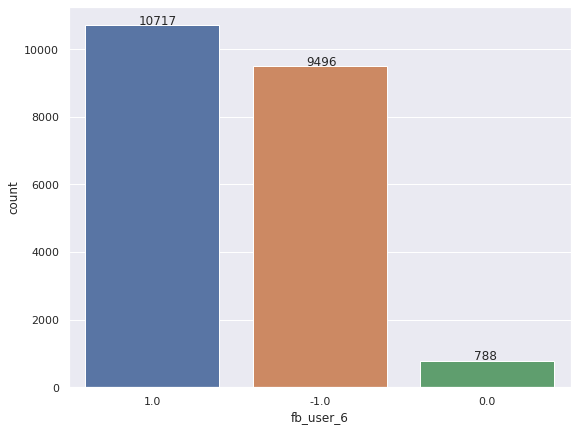

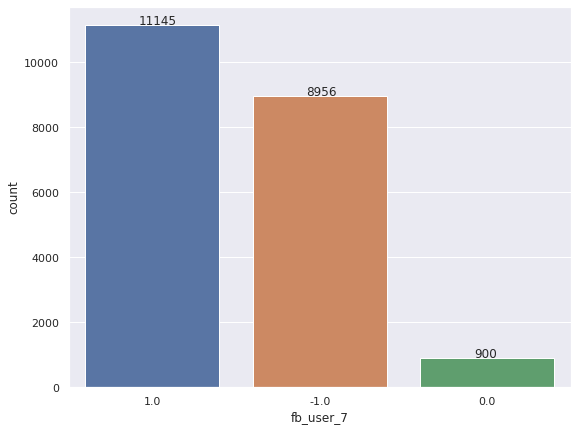

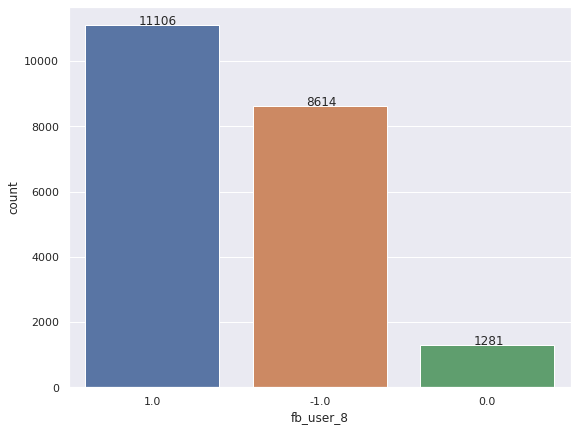

In [72]:
# Plotting Categorical Data with a loop
for col in cat_cols:
    # Plotting Categorical Data:
    univar_plot_byCheckingColTyp(df_train_filtered, col, 1)

Observation: We can see there data is well adjusted for category columns and for numerical columns there are outliyers which we treat them later


#### Bivariable Analysis

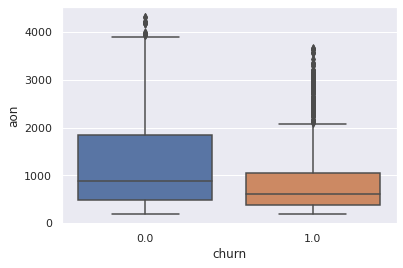

In [73]:
bivariate(df_train_filtered, 'churn', 'aon')

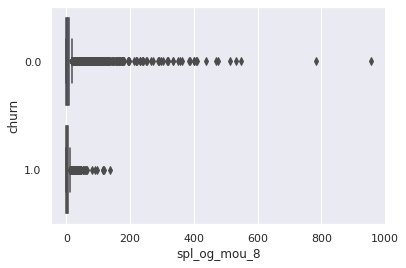

In [74]:
bivariate(df_train_filtered, 'spl_og_mou_8', 'churn')

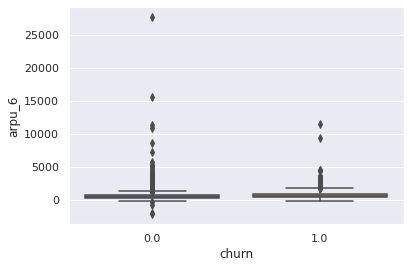

In [75]:
bivariate(df_train_filtered, 'churn', 'arpu_6')

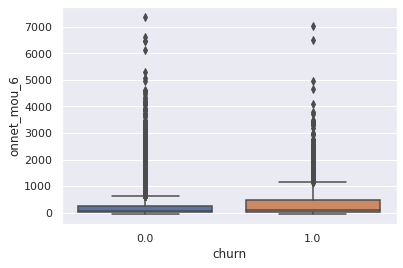

In [76]:
bivariate(df_train_filtered, 'churn', 'onnet_mou_6')

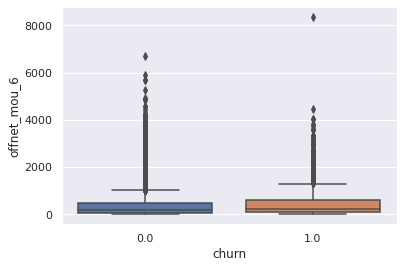

In [77]:
bivariate(df_train_filtered, 'churn', 'offnet_mou_6')

In [78]:
pd.crosstab(df_train_filtered.churn, df_train_filtered.night_pck_user_8, normalize='columns')*100

night_pck_user_8,-1.0,0.0,1.0
churn,,,
0.0,89.528674,97.145921,96.590909
1.0,10.471326,2.854079,3.409091


In [79]:
pd.crosstab(df_train_filtered.churn, df_train_filtered.sachet_3g_8)

sachet_3g_8,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,23.0,25.0,29.0,30.0,38.0,41.0
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,17579,1342,345,159,84,70,34,29,22,16,11,9,9,8,3,4,2,2,3,1,3,2,2,1,1,1,1,1
1.0,1203,37,3,6,3,1,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


<AxesSubplot:>

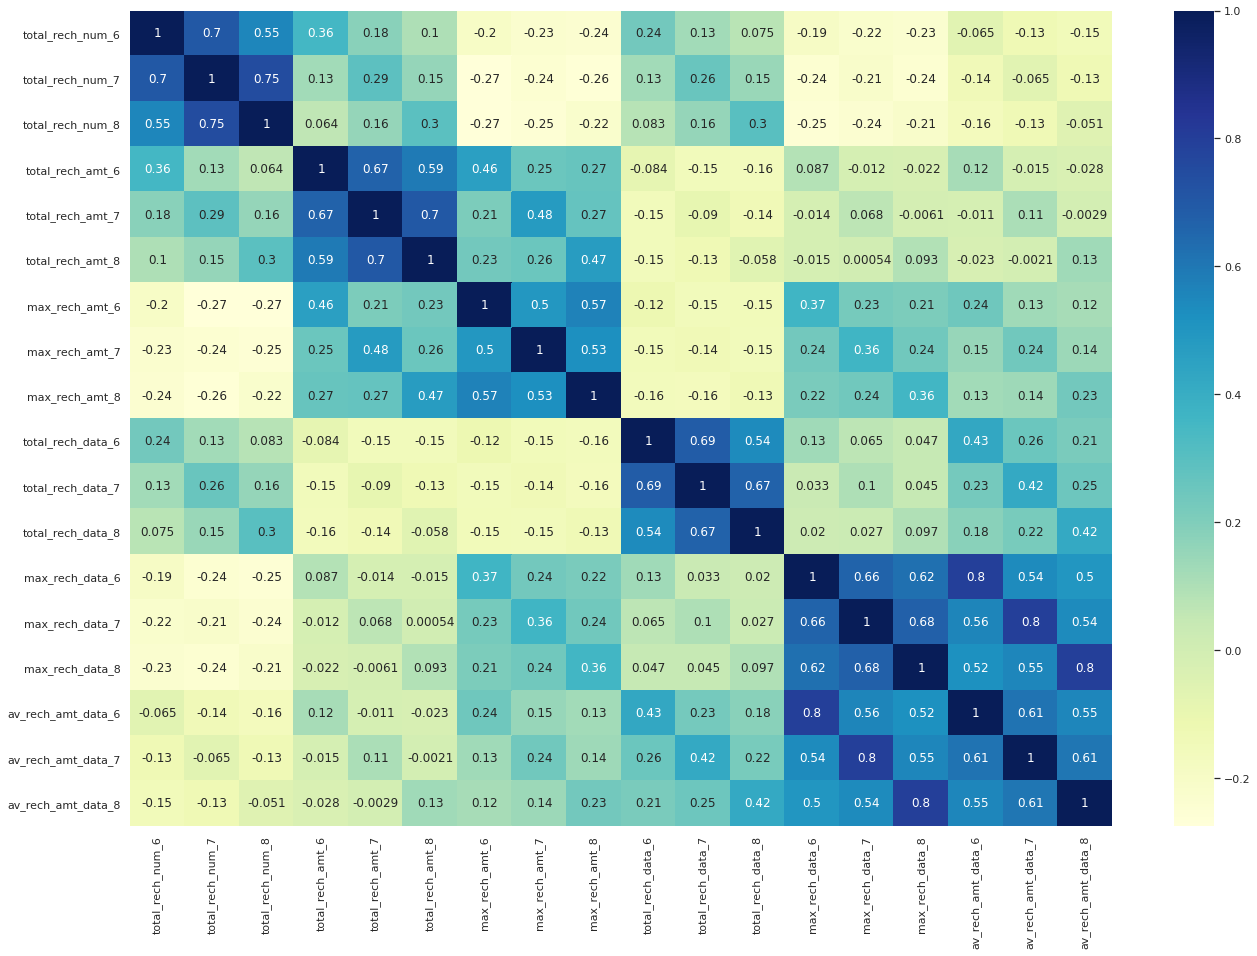

In [80]:
#Histogram to check the co-relation
rech_df = df_train_filtered.filter(regex = 'rech')
print(rech_df.columns)
fig = plt.figure(figsize=(22, 15))
sns.heatmap(rech_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'loc_ic_mou_6',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6',
       'isd_ic_mou_7', 'isd_ic_mou_8'],
      dtype='object')


<AxesSubplot:>

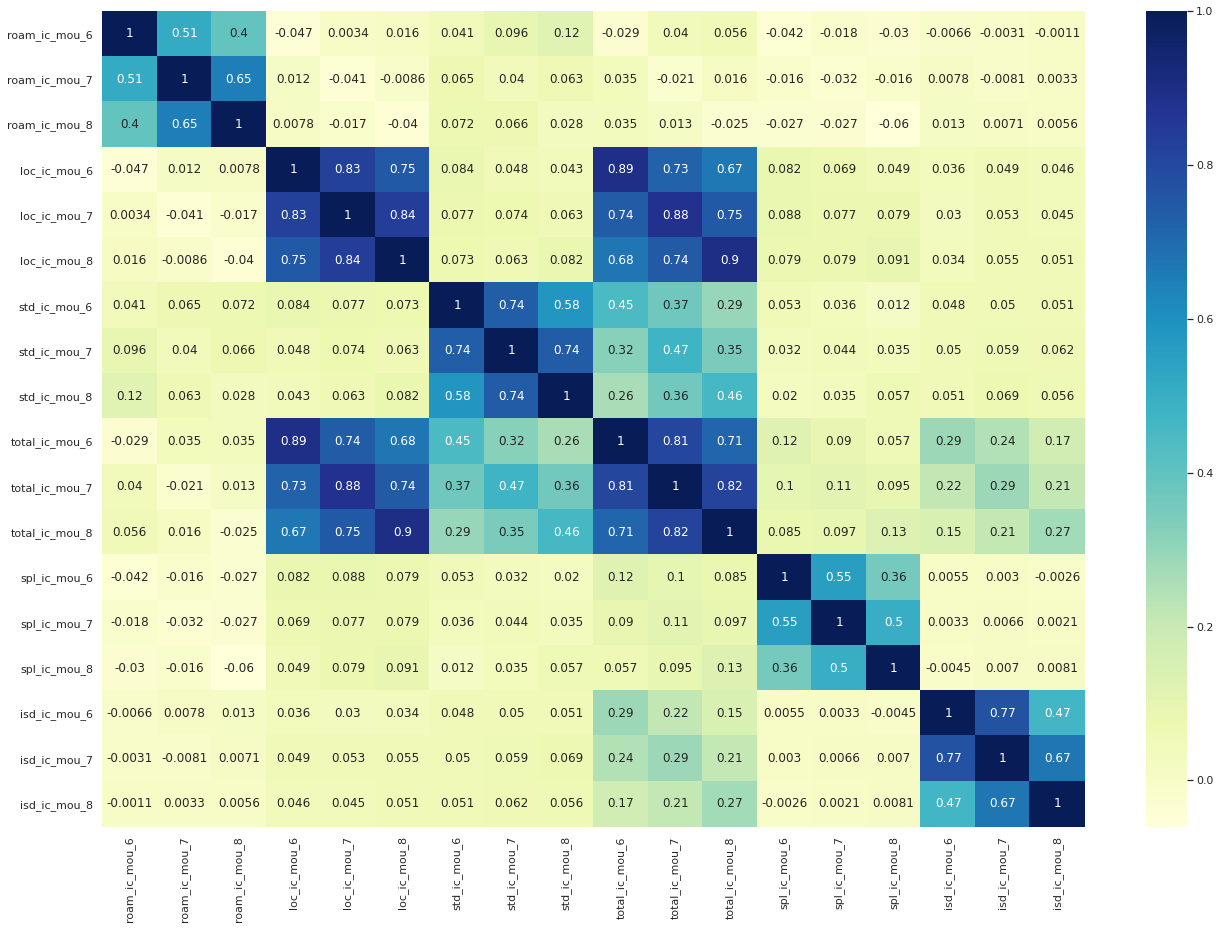

In [81]:
rech_df = df_train_filtered.filter(regex = 'ic_mou')
print(rech_df.columns)
fig = plt.figure(figsize=(22, 15))
sns.heatmap(rech_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

Index(['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8'],
      dtype='object')


<AxesSubplot:>

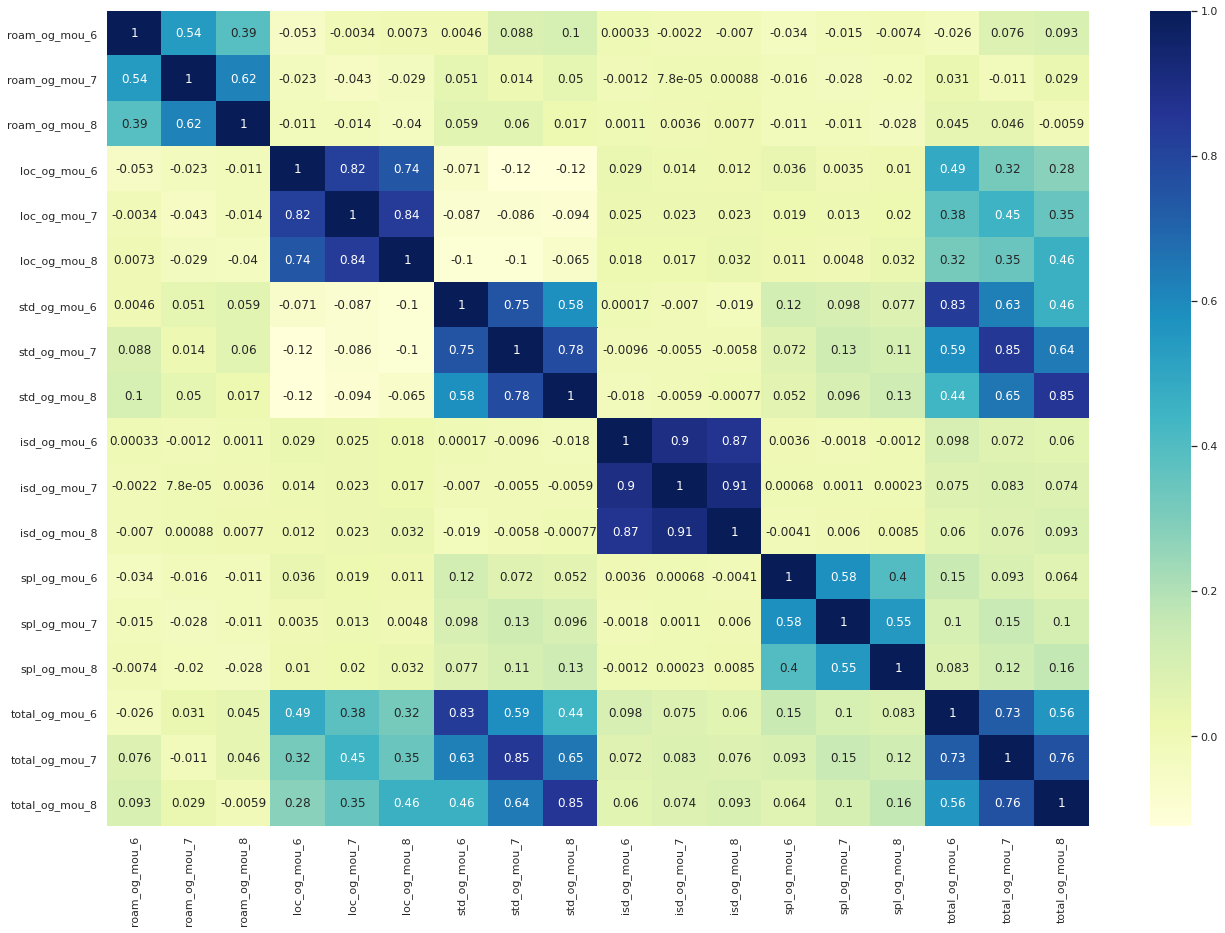

In [82]:
rech_df = df_train_filtered.filter(regex = 'og_mou')
print(rech_df.columns)
fig = plt.figure(figsize=(22, 15))
sns.heatmap(rech_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

#### **Observations:**
* We can clearly see that some features are highly correlated with each other

#### **Standard deviation outlier treatment**

In [83]:
num_cols = [col for col in df_train_filtered.columns if col in num_cols]
cat_cols = [col for col in df_train_filtered.columns if col in cat_cols]

In [84]:
# cap outliers in the numeric columns
df_train_filtered[num_cols] = df_train_filtered[num_cols].apply(std_dev_cap_outliers, axis=0)

In [85]:
df_train_filtered.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000
mean,535.389683,552.092059,545.189611,247.365546,264.795484,250.941938,362.389375,377.606044,363.260747,15.589891,11.909882,12.815836,25.780354,18.981804,19.329115,81

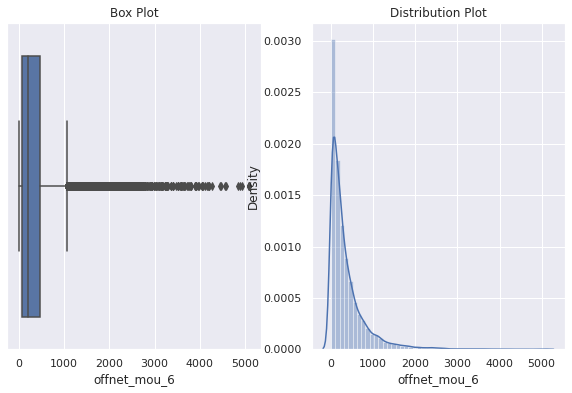

count    21001.000000
mean       362.389375
std        468.971488
min          0.000000
25%         73.340000
50%        207.310000
75%        467.260000
max       5093.645614
Name: offnet_mou_6, dtype: float64


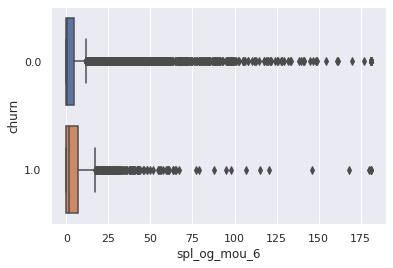

In [86]:
# Validate previous Univariable and Bivariable squewness
univariate(df_train_filtered, 'offnet_mou_6')
bivariate(df_train_filtered, 'spl_og_mou_6', 'churn')

#### **Preparing the Data for Modeling**

In [87]:
# change churn to numeric
df_train_filtered['churn'] = pd.to_numeric(df_train_filtered['churn'])

#### **Splitting TRAIN data into Train Test**

In [88]:
# divide data into train and test
X = df_train_filtered.drop("churn", axis = 1)
y = df_train_filtered.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)

In [89]:
X_TEST_CSV = df_test_filtered

In [90]:
# print shapes of train and test sets
X_train.shape
y_train.shape
X_test.shape
y_test.shape
X_TEST_CSV.shape


(15750, 139)

(15750,)

(5251, 139)

(5251,)

(30000, 139)

#### **Aggregating the Categorical columns**

In [91]:
train = pd.concat([X_train, y_train], axis=1)

In [92]:
# Replace categories with aggregated values in each categorical column
mapping = {'night_pck_user_6' : {-1: train.groupby('night_pck_user_6').churn.mean()[-1], 0: train.groupby('night_pck_user_6').churn.mean()[0], 1: train.groupby('night_pck_user_6').churn.mean()[1]},
           'night_pck_user_7' : {-1: train.groupby('night_pck_user_7').churn.mean()[-1], 0: train.groupby('night_pck_user_7').churn.mean()[0], 1: train.groupby('night_pck_user_7').churn.mean()[1]},
           'night_pck_user_8' : {-1: train.groupby('night_pck_user_8').churn.mean()[-1], 0: train.groupby('night_pck_user_8').churn.mean()[0], 1: train.groupby('night_pck_user_8').churn.mean()[1]},
           'fb_user_6'        : {-1: train.groupby('fb_user_6').churn.mean()[-1], 0: train.groupby('fb_user_6').churn.mean()[0], 1: train.groupby('fb_user_6').churn.mean()[1]},
           'fb_user_7'        : {-1: train.groupby('fb_user_7').churn.mean()[-1], 0: train.groupby('fb_user_7').churn.mean()[0], 1: train.groupby('fb_user_7').churn.mean()[1]},
           'fb_user_8'        : {-1: train.groupby('fb_user_8').churn.mean()[-1], 0: train.groupby('fb_user_8').churn.mean()[0], 1: train.groupby('fb_user_8').churn.mean()[1]}
          }
X_train.replace(mapping, inplace = True)
X_test.replace(mapping, inplace = True)

# for TEST
X_TEST_CSV.replace(mapping, inplace = True)

In [93]:
# Replace categories with aggregated values in each categorical column for TEST
X_TEST_CSV.replace(mapping, inplace = True)

In [94]:
# check data type of categorical columns - make sure they are numeric
X_train[[col for col in cat_cols if col not in ['churn']]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15750 entries, 1217 to 12103
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  15750 non-null  float64
 1   night_pck_user_7  15750 non-null  float64
 2   night_pck_user_8  15750 non-null  float64
 3   fb_user_6         15750 non-null  float64
 4   fb_user_7         15750 non-null  float64
 5   fb_user_8         15750 non-null  float64
dtypes: float64(6)
memory usage: 861.3 KB


In [95]:
#for TEST
X_TEST_CSV[[col for col in cat_cols]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  30000 non-null  float64
 1   night_pck_user_7  30000 non-null  float64
 2   night_pck_user_8  30000 non-null  float64
 3   fb_user_6         30000 non-null  float64
 4   fb_user_7         30000 non-null  float64
 5   fb_user_8         30000 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB


#### **PCA - Principal Component Analysis**

In [96]:
# Apply PCA to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [97]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [98]:
# Extract PCA model from pipeline
pca = pca.named_steps['pca']

# PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       12.08
1       21.52
2       27.74
3       32.39
4       36.69
5       39.96
6       42.84
7       45.50
8       47.99
9       50.40
10      52.72
11      54.94
12      57.03
13      58.92
14      60.69
15      62.36
16      63.87
17      65.23
18      66.57
19      67.84
20      69.12
21      70.30
22      71.47
23      72.58
24      73.59
25      74.55
26      75.49
27      76.42
28      77.29
29      78.07
30      78.84
31      79.57
32      80.26
33      80.93
34      81.58
35      82.20
36      82.80
37      83.39
38      83.96
39      84.52
40      85.06
41      85.61
42      86.13
43      86.62
44      87.09
45      87.55
46      87.99
47      88.40
48      88.81
49      89.21
50      89.60
51      89.98
52      90.35
53      90.69
54      91.02
55      91.33
56      91.64
57      91.95
58      92.25
59      92.54
60      92.83
61      93.10
62      93.37
63      93.63
64      93.89
65      94.14
66      94.38
67      94.62
68      94.85
69      95.07
70      95.28
71    

<Figure size 630x360 with 0 Axes>

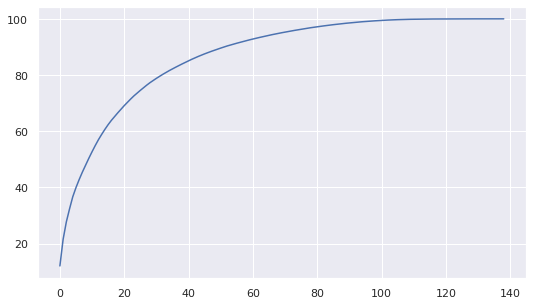

In [99]:
# Plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20, 100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)


#### **Observations:**
* 60 components explain 92.83% variance
* 80 components explain 97.18% variance
* 100 components explain 99.45% variance

#### **Model Building**

*Implementing the Model using Logistic Regression, Random Forest, CrossValidation from SciKit Learn*

##### **PCA and Logistic Regression**

In [100]:
# Create Pipeline with Scaler, PCA, and modeling with LogisticRegression
PCA_VARS = 100
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight = 'balanced'))
        ]
pipeline_pca_rl = Pipeline(steps)

In [101]:
# fit model
pipeline_pca_rl.fit(X_train, y_train)

# check score on train data
pipeline_pca_rl.score(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=100)),
                ('logistic', LogisticRegression(class_weight='balanced'))])

0.8358095238095238

#### **Evaluate on train_test data**

In [102]:
# predict churn on test data
y_pred = pipeline_pca_rl.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Check Precision, Accuracy, Recall and F1-Score
print("Precision: ", round(precision_score(y_test, y_pred),4))
print("Accuracy: ",  round(accuracy_score(y_test, y_pred),4))
print("Recall: ",    round(recall_score(y_test, y_pred),4))
print("F1-Score: ",  round(f1_score(y_test, y_pred),4))

# Check area under curve
y_pred_prob = pipeline_pca_rl.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[4123  814]
 [  61  253]]
Precision:  0.2371
Accuracy:  0.8334
Recall:  0.8057
F1-Score:  0.3664
AUC:    	 0.8821


#### Evaluate on TEST_CSV data

In [103]:
# predict churn on test_csv data
y_pred_test_csv_lr = pipeline_pca_rl.predict(X_TEST_CSV)

In [104]:
#creating the file to test in kaggle
#y_rf = pd.DataFrame(y_pred_test_csv_lr)
#result = pd.concat([df_test_unseen.id, y_rf], axis=1, ignore_index=True)
#result = result.rename(columns={0: "id", 1: "churn_probability"})
#result.to_csv(RESULT_TEST_FILEPATH, index=False)
#result
#kaggle score is 0.91390

#### Hyperparameter Tuning for PCA and Logistic Regression

In [105]:
# class imbalance
y_train.value_counts() / y_train.shape

0.0    0.940127
1.0    0.059873
Name: churn, dtype: float64

In [106]:
# PCA
pca = PCA()

# Logistic Regression - the class weight is used to handle class imbalance
# It adjusts the cost function
logistic = LogisticRegression(class_weight={0: 0.1, 1: 0.9})

# Create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# Compile Pipeline
pipeline_pca_rl_tunned = Pipeline(steps)

# Hyperparameter Space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# Create 5 Folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
rl_model_tunned = GridSearchCV(estimator=pipeline_pca_rl_tunned, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)


In [107]:
# Fit Model
rl_model_tunned.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [108]:
# Cross Validation Results
pd.DataFrame(rl_model_tunned.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.652999,0.062182,0.000000,0.000000,0.1,l1,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l1', 'pca__n_components': 60}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
1,0.920414,0.094212,0.000000,0.000000,0.1,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1', 'pca__n_components': 80}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
2,0.949737,0.133541,0.030482,0.007209,0.1,l2,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 60}",0.880960,0.862853,0.872982,0.869796,0.886661,0.874650,0.008362,10
3,1.237954,0.093045,0.028747,0.003466,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 80}",0.883399,0.871394,0.875405,0.873516,0.882161,0.877175,0.004765,1
4,0.709365,0.048250,0.000000,0.000000,0.5,l1,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l1', 'pca__n_components': 60}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
5,0.929275,0.103764,0.000000,0.000000,0.5,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1', 'pca__n_components': 80}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
6,1.018760,0.110094,0.029901,0.004993,0.5,l2,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l2', 'pca__n_components': 60}",0.880727,0.863898,0.875283,0.870554,0.887788,0.875650,0.008214,9
7,1.430554,0.059747,0.042622,0.017663,0.5,l2,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l2', 'pca__n_components': 80}",0.882253,0.869417,0.874880,0.872998,0.881116,0.876133,0.004874,5
8,0.726324,0.139657,0.000000,0.000000,1,l1,60,"{'logistic__C': 1, 'logistic__penalty': 'l1', 'pca__n_components': 60}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
9,0.967042,0.075510,0.000000,0.000000,1,l1,80,"{'logistic__C': 1, 'logistic__penalty': 'l1', 'pca__n_components': 80}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,28


In [109]:
# Print Best Hyperparameters
print("Best AUC: ", rl_model_tunned.best_score_)
print("Best HyperParameters: ", rl_model_tunned.best_params_)

Best AUC:  0.8771750716761207
Best HyperParameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [110]:
# Predict Churn on Train.Test Data
y_pred = rl_model_tunned.predict(X_test)

# Create Confusion Matrix again
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Check Precision, Accuracy, Recall and F1-Score
print("Precision: ", round(precision_score(y_test, y_pred),4))
print("Accuracy: ",  round(accuracy_score(y_test, y_pred),4))
print("Recall: ",    round(recall_score(y_test, y_pred),4))
print("F1-Score: ",  round(f1_score(y_test, y_pred),4))

# Check area under curve
y_pred_prob = rl_model_tunned.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[4496  441]
 [  87  227]]
Precision:  0.3398
Accuracy:  0.8994
Recall:  0.7229
F1-Score:  0.4623
AUC:    	 0.8813


#### Evaluate on TEST_CSV data

In [111]:
# predict churn on test_csv data
y_pred_test_csv_lr_tunned = rl_model_tunned.predict(X_TEST_CSV)

In [112]:
#creating the file to test in kaggle
#y_rf = pd.DataFrame(y_pred_test_csv_lr_tunned)
#result = pd.concat([df_test_unseen.id, y_rf], axis=1, ignore_index=True)
#result = result.rename(columns={0: "id", 1: "churn_probability"})
#result.to_csv(RESULT_TEST_FILEPATH, index=False)
#result
#kaggle score is -

#### Random Forest

In [113]:
# Random Forest
## - The class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# Hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
rf_model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [114]:
# fit model
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [115]:
# print best hyperparameters
print("Best AUC: ", rf_model.best_score_)
print("Best hyperparameters: ", rf_model.best_params_)

Best AUC:  0.9226725120839406
Best hyperparameters:  {'criterion': 'gini', 'max_features': 0.4}


In [116]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Check Precision, Accuracy, Recall and F1-Score
print("Precision: ", round(precision_score(y_test, y_pred), 4))
print("Accuracy: ",  round(accuracy_score(y_test, y_pred), 4))
print("Recall: ",    round(recall_score(y_test, y_pred), 4))
print("F1-Score: ",  round(f1_score(y_test, y_pred), 4))

# Check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[4902   35]
 [ 188  126]]
Precision:  0.7826
Accuracy:  0.9575
Recall:  0.4013
F1-Score:  0.5305
AUC:    	 0.9077


#### Evaluate on TEST_CSV data

In [117]:
# predict churn on test_csv data
y_pred_test_csv_rf = rf_model.predict(X_TEST_CSV)

In [118]:
#creating the file to test in kaggle
#y_rf = pd.DataFrame(y_pred_test_csv_rf)
#result = pd.concat([df_test_unseen.id, y_rf], axis=1, ignore_index=True)
#result = result.rename(columns={0: "id", 1: "churn_probability"})
#result.to_csv(RESULT_TEST_FILEPATH, index=False)
#result
#kaggle score is -

#### **Observations:**
* The best model is Random Forest with better Scores than LogisticRegression.

#### **Choosing best features**

In [119]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf2_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

12


In [120]:
# Fit Model
rf2_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.5s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=12,
                       oob_score=True, random_state=4, verbose=1)

In [121]:
# OOB Score
rf2_model.oob_score_

0.9577142857142857

In [122]:
len(X_train.columns)

139

In [123]:
# predict churn on test data
y_pred = rf2_model.predict(X_test)

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Check Precision, Accuracy, Recall and F1-Score
print("Precision: ", round(precision_score(y_test, y_pred),4))
print("Accuracy: ",  round(accuracy_score(y_test, y_pred),4))
print("Recall: ",    round(recall_score(y_test, y_pred),4))
print("F1-Score: ",  round(f1_score(y_test, y_pred),4))

# Check area under curve
y_pred_prob = rf2_model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[4914   23]
 [ 197  117]]
Precision:  0.8357
Accuracy:  0.9581
Recall:  0.3726
F1-Score:  0.5154
AUC:    	 0.9077


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


#### Feature Importance

In [124]:
# Predictors
features = df_train_filtered.drop('churn', axis=1).columns

# Feature_Importance
importance = rf2_model.feature_importances_

# Create Dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance * 100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# Sort Features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())

feature_importance

Sum of importance= 99.99999999999999


,variables,importance_percentage
0,roam_ic_mou_8,7.199179
1,roam_og_mou_8,6.588078
2,total_ic_mou_8,4.423214
3,total_og_mou_8,3.863888
4,loc_og_mou_8,3.786846
5,last_day_rch_amt_8,3.707332
6,total_rech_amt_8,2.880152
7,loc_ic_mou_8,2.854118
8,loc_ic_t2m_mou_8,2.320120
9,av_rech_amt_data_8,2.230463


#### Extracting Top 20 features

In [125]:
# extract top 'n' features
top_n = 20
top_features = feature_importance.variables[0:top_n]

<AxesSubplot:>

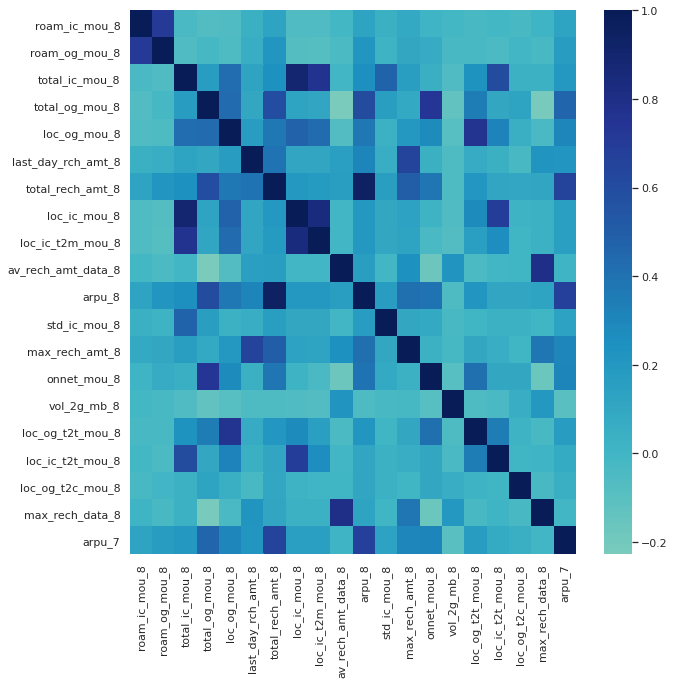

In [126]:
# plot feature correlation
plt.rcParams["figure.figsize"] = (10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap='YlGnBu')

In [127]:
top_features

0          roam_ic_mou_8
1          roam_og_mou_8
2         total_ic_mou_8
3         total_og_mou_8
4           loc_og_mou_8
5     last_day_rch_amt_8
6       total_rech_amt_8
7           loc_ic_mou_8
8       loc_ic_t2m_mou_8
9     av_rech_amt_data_8
10                arpu_8
11          std_ic_mou_8
12        max_rech_amt_8
13           onnet_mou_8
14           vol_2g_mb_8
15      loc_og_t2t_mou_8
16      loc_ic_t2t_mou_8
17      loc_og_t2c_mou_8
18       max_rech_data_8
19                arpu_7
Name: variables, dtype: object

In [128]:
X_train = X_train[top_features]
X_test = X_test[top_features]

In [129]:
# Logistic Regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [130]:
# Fit Model
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [131]:
# Print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8673031814897906
Best hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2'}


In [132]:
X_train.columns

Index(['roam_ic_mou_8', 'roam_og_mou_8', 'total_ic_mou_8', 'total_og_mou_8',
       'loc_og_mou_8', 'last_day_rch_amt_8', 'total_rech_amt_8',
       'loc_ic_mou_8', 'loc_ic_t2m_mou_8', 'av_rech_amt_data_8', 'arpu_8',
       'std_ic_mou_8', 'max_rech_amt_8', 'onnet_mou_8', 'vol_2g_mb_8',
       'loc_og_t2t_mou_8', 'loc_ic_t2t_mou_8', 'loc_og_t2c_mou_8',
       'max_rech_data_8', 'arpu_7'],
      dtype='object')

#### Prepare the Test.csv Predictions file for Kraggle

In [133]:
y_lr = pd.DataFrame(y_pred_test_csv_lr)
y_lr_tunned = pd.DataFrame(y_pred_test_csv_lr_tunned) 
y_rf = pd.DataFrame(y_pred_test_csv_rf)

X_TEST_CSV.head()
df_test_unseen.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5.0,5.0,4.0,103.0,90.0,60.0,50.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068671,0.078788,0.103619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068671,0.078788,0.103619,1692.0,0.00,0.00,0.00
1,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5.0,4.0,5.0,500.0,500.0,500.0,250.0,250.0,250.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068671,0.078788,0.103619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068671,0.078788,0.103619,2533.0,0.00,0.00,0.00
2,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,6.0,9.0,5.0,500.0,1000.0,1000.0,300.0,500.0,500.0,0

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

In [134]:
result = pd.concat([df_test_unseen.id, y_rf], axis=1, ignore_index=True)
result = result.rename(columns={0: "id", 1: "churn_probability"})


In [135]:
# Saving the result of the RandomForest model with the TEST Data
result.to_csv(RESULT_TEST_FILEPATH, index=False)

In [136]:
result

,id,churn_probability
0,69999,0.0
1,70000,0.0
2,70001,1.0
3,70002,0.0
4,70003,0.0
...,...,...
29995,99994,0.0
29996,99995,0.0
29997,99996,0.0
29998,99997,0.0


# Conclusions and Observations

In [137]:
## Comments
# * The best model is RandomForest with perfect scores 1.0 with the testing.
# * Preprocessing the data is important.
# * Kraggle Accuracy:  -
# Since the submition to Kraggle gave a 0.94374 Accuracy Score, seems that the Random Fores model overfitted.
# This can be given the data rows that are eliminated from the TRAIN Data, we do not have a treatement of similar rows in TEST_CSV data.

## Top 20 Features:
1. roam_ic_mou_8
2. roam_og_mou_8
3. total_ic_mou_8
4. total_og_mou_8
5. loc_og_mou_8
6. last_day_rch_amt_8
7. total_rech_amt_8
8. loc_ic_mou_8
9. loc_ic_t2m_mou_8
10. av_rech_amt_data_8
11. arpu_8
12. std_ic_mou_8
13. max_rech_amt_8
14. onnet_mou_8
15. vol_2g_mb_8
16. loc_og_t2t_mou_8
17. loc_ic_t2t_mou_8
18. loc_og_t2c_mou_8
19. max_rech_data_8
20. arpu_7